## A notebook for the preprocessing of the standard data: 

- concatenate all participant's csv files 
- calculate the accuracy for each participant a) for the whole task and b) for each individual scene
- export the accuracies in a new csv file / table (to be used for statistical analysis)

In [1]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Concatenate all csv files

In [2]:
# read path with all csvs
all_path = "ERPLogsStandard/"

# Concatenate all cleaned CSVs (fix header whitespace)
all_files_list = os.listdir(all_path)
all_dfs = []

for f in all_files_list:
    df = pd.read_csv(os.path.join(all_path, f), sep=';')  
    df.columns = df.columns.str.strip()  # Strip whitespace
    all_dfs.append(df)

df_concat = pd.concat(all_dfs, ignore_index=True)

print(df_concat.head())

df_concat.to_csv('standard_all_merged.csv', index=False)

print("Merged CSV saved as 'standard_all_merged.csv'")

   Timestamp                                         ObjectName      ID  \
0     114.74  ERPTags1Standard ERPFlashTag2D (4) ERPFlashTag...  28CO38   
1     118.36  ERPTags2Standard ERPFlashTag2D (4) ERPFlashTag...  28CO38   
2     118.71  ERPTags2Standard ERPFlashTag2D (4) ERPFlashTag...  28CO38   
3     121.21  ERPTags2Standard ERPFlashTag2D (3) ERPFlashTag...  28CO38   
4     126.75  ERPTags3Standard ERPFlashTag2D (1) ERPFlashTag...  28CO38   

   correct  scene  PlaceInOrder condition  
0        1      1             2  standard  
1        0      1             2  standard  
2        0      1             2  standard  
3        1      1             2  standard  
4        1      1             2  standard  
Merged CSV saved as 'standard_all_merged.csv'


### Clean up the data

There are some selections logged in the csv file that cannot be considered as actual selections of the participants, i.e. false positive ('on-off' or 'double') selections that happened within less than one second, likely due to just falling under the confidence threshold of the BCI classifier (for example due to movements). 
Selections that are logged less than a second after the previous one are therefore removed from the data, as they represent inaccuracies of the BCI system and not the performance of the participant.

In [3]:
# extract tag & class number from object name
df_concat['TagNum'] = df_concat['ObjectName'].str.extract(r'ERPTags(\d+)').astype(float)
df_concat['ClassNum'] = df_concat['ObjectName'].str.extract(r'\((\d+)\)').astype(float) 

# initialize column to mark false positive 
df_concat['FalsePositives'] = pd.NA

# apply marking logic: selections (within the same group) with less than 1 sec between them are marked 
for (id_val, scene_val), group in df_concat.groupby(['ID', 'scene']):
    group = group.reset_index()
    for i in range(len(group) - 1):
        tag_current = group.loc[i, 'TagNum']
        tag_next = group.loc[i + 1, 'TagNum']
        class_current = group.loc[i, 'ClassNum']
        class_next = group.loc[i + 1, 'ClassNum']
        # check that selection is within the same group 
        if tag_next == tag_current and class_current == class_next:
            time_diff = group.loc[i + 1, 'Timestamp'] - group.loc[i, 'Timestamp']
            # mark if time difference is less than 1 sec 
            if time_diff < 1:
                df_concat.at[group.loc[i + 1, 'index'], 'FalsePositives'] = 'FP'

#print(df_concat)
df_marked = df_concat
df_marked.to_csv('standard_all_merged_marked.csv', index=False)

# remove all rows marked as false positives 
df_concat = df_concat[df_concat.FalsePositives != 'FP'].reset_index(drop=True)

df_concat.to_csv('standard_all_merged_cleaned.csv', index=False)

df_concat

,Timestamp,ObjectName,ID,correct,scene,PlaceInOrder,condition,TagNum,ClassNum,FalsePositives
0,114.74,ERPTags1Standard ERPFlashTag2D (4) ERPFlashTag...,28CO38,1,1,2,standard,1.0,4.0,<NA>
1,118.36,ERPTags2Standard ERPFlashTag2D (4) ERPFlashTag...,28CO38,0,1,2,standard,2.0,4.0,<NA>
2,121.21,ERPTags2Standard ERPFlashTag2D (3) ERPFlashTag...,28CO38,1,1,2,standard,2.0,3.0,<NA>
3,126.75,ERPTags3Standard ERPFlashTag2D (1) ERPFlashTag...,28CO38,1,1,2,standard,3.0,1.0,<NA>
4,130.28,ERPTags4Standard ERPFlashTag2D (1) ERPFlashTag...,28CO38,0,1,2,standard,4.0,1.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
573,248.68,ERPTags4Standard3 ERPFlashTag2D (2) ERPFlashTa...,11LK66,1,3,1,standard,4.0,2.0,<NA>
574,252.96,ERPTags5Standard3 ERPFlashTag2D (1) ERPFlashTa...,11LK66,1,3,1,standard,5.0,1.0,<NA>
575,257.24,ERPTags6Standard3 ERPFlashTag2D (4) ERPFlashTa...,11LK66,1,3,1,standard,6.0,4.0,<NA>
576,260.80,ERPTags7Standard3 ERPFlashTag2D (3) ERPFlashTa...,11LK66,1,3,1,standard,7.0,3.0,<NA>


In [4]:
# get table of the percentage per participant that has been excluded 

fp_table = (
    df_marked.groupby('ID')
    .apply(lambda x: (x['FalsePositives'] == 'FP').sum() / len(x) * 100)
    .reset_index(name='FP_Percentage')
)

fp_table

,ID,FP_Percentage
0,02JO85,6.060606
1,07az26,11.904762
2,08MA21,2.127660
3,09HA13,2.857143
4,10PE77,4.651163
5,11LK66,0.000000
6,15JO96,8.108108
7,17BE17,12.820513
8,17HE69,2.325581
9,19RA95,20.408163


### Accuracy for each participant 

#### Overall accuracy for all scenes 

In [5]:
# for each participant ID divide the number of correct choices (sum) by the overall number of selections logged 
# here this is equivalent to the mean 

df_complete = pd.read_csv('standard_all_merged_cleaned.csv')
#print(df_complete.head())


# Compute overall accuracy per participant
participant_accuracy = df_complete.groupby('ID')['correct'].mean().reset_index()
participant_accuracy.columns = ['ID', 'Accuracy']

# Select one row per participant to get 'Place in order' and 'Condition'
meta_info = df_complete[['ID', 'PlaceInOrder', 'condition']].drop_duplicates(subset='ID')

# Merge meta info into the accuracy table
participant_accuracy = participant_accuracy.merge(meta_info, on='ID', how='left')

print(participant_accuracy)

# put IDs with corresponding accuracy score, place in order, and condition into new csv 
participant_accuracy.to_csv('standard_overall_accuracy.csv', index=False)

        ID  Accuracy  PlaceInOrder condition
0   02JO85  0.741935             2  standard
1   07az26  0.621622             2  standard
2   08MA21  0.500000             1  standard
3   09HA13  0.705882             2  standard
4   10PE77  0.560976             2  standard
5   11LK66  0.888889             1  standard
6   15JO96  0.705882             1  standard
7   17BE17  0.647059             1  standard
8   17HE69  0.571429             2  standard
9   19RA95  0.461538             2  standard
10  21EL67  0.631579             1  standard
11  27JA04  0.857143             2  standard
12  28CO38  0.600000             2  standard
13  29MA29  0.700000             1  standard
14   2BR68  0.605263             1  standard
15   2MA07  0.615385             1  standard


#### Accuracy per scene 

In [6]:
df_complete = pd.read_csv('standard_all_merged_cleaned.csv')
#print(df_complete.head())


# for each participant ID group by scene number 
# divide the number of correct choices by the overall number of selections logged for each scene 
participant_scene_accuracy = df_complete.groupby(['ID', 'scene'])['correct'].mean().reset_index()
participant_scene_accuracy.columns = ['ID', 'scene', 'SceneAccuracy']
#print(participant_scene_accuracy)

# Select one row per participant to get 'Place in order' and 'Condition'
meta_info = df_complete[['ID','scene', 'PlaceInOrder', 'condition']].drop_duplicates(subset=['ID', 'scene'])
#print(meta_info)

# Merge meta info into the accuracy table
participant_scene_accuracy = participant_scene_accuracy.merge(meta_info, on=['ID', 'scene'], how='left')

print(participant_scene_accuracy)

# put put IDs with corresponding three accuracy scores, place in order, and condition into new csv 
participant_scene_accuracy.to_csv('standard_perscene_accuracy.csv', index=False)

        ID  scene  SceneAccuracy  PlaceInOrder condition
0   02JO85      1       0.875000             2  standard
1   02JO85      2       0.615385             2  standard
2   02JO85      3       0.800000             2  standard
3   07az26      1       0.615385             2  standard
4   07az26      2       0.666667             2  standard
5   07az26      3       0.583333             2  standard
6   08MA21      1       0.533333             1  standard
7   08MA21      2       0.470588             1  standard
8   08MA21      3       0.500000             1  standard
9   09HA13      1       0.666667             2  standard
10  09HA13      2       0.727273             2  standard
11  09HA13      3       0.727273             2  standard
12  10PE77      1       0.533333             2  standard
13  10PE77      2       0.615385             2  standard
14  10PE77      3       0.538462             2  standard
15  11LK66      1       0.888889             1  standard
16  11LK66      2       0.80000

### Some EDA

In [7]:
participant_scene_accuracy.groupby('scene')['SceneAccuracy'].mean()

scene
1    0.669992
2    0.665579
3    0.639974
Name: SceneAccuracy, dtype: float64

scene
1    0.669992
2    0.665579
3    0.639974
Name: SceneAccuracy, dtype: float64


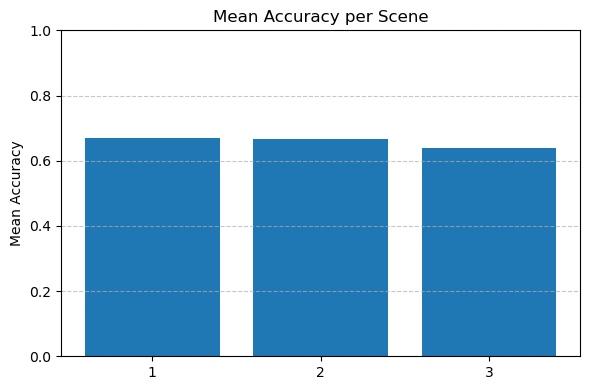

In [8]:
# plot the average accuracies for all three scenes 

# Calculate means for visualization
means = participant_scene_accuracy.groupby('scene')['SceneAccuracy'].mean()

print(means)

# Bar plot of condition means 
plt.figure(figsize=(6, 4))
plt.bar(['1', '2', '3'], means)
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per Scene')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

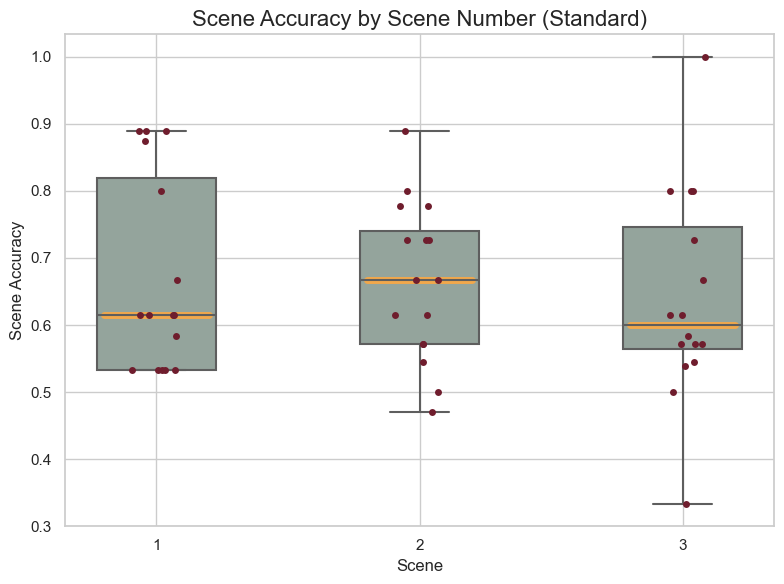

In [9]:
# boxplots for the individual scene accuracies 

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Custom color
box_color = "#91A79C"

# Initialize the plot
plt.figure(figsize=(8, 6))

# Draw boxplot
ax = sns.boxplot(
    x='scene', y='SceneAccuracy', data=participant_scene_accuracy,
    color=box_color,
    width=0.45,
    fliersize=0,
    linewidth=1.5
)

# Overlay datapoints
sns.stripplot(
    x='scene', y='SceneAccuracy', data=participant_scene_accuracy,
    color='#6F1D2D', size=5, jitter=True, alpha=1
)

# Draw thicker median lines manually
median = participant_scene_accuracy.groupby("scene")["SceneAccuracy"].median()
for i, (scene, med_val) in enumerate(median.items()):
    plt.plot([i - 0.2, i + 0.2], [med_val, med_val], color='#F1A84C', lw=5)

# Customize labels and grid
plt.title('Scene Accuracy by Scene Number (Standard)', fontsize=16)
plt.xlabel('Scene')
plt.ylabel('Scene Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()
